In [47]:
import time
from tqdm import tqdm # Cool progress bar
import random
import numpy as np
import pandas as pd
import h5py
import cv2
import re
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *
from visualization import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras import backend as K
from sklearn.model_selection import ParameterGrid, train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu as Relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

In [48]:
X_train, y_train, Kaggle_data = get_data()

Datasets in file: ['X', 'y']
Datasets in file: ['X']


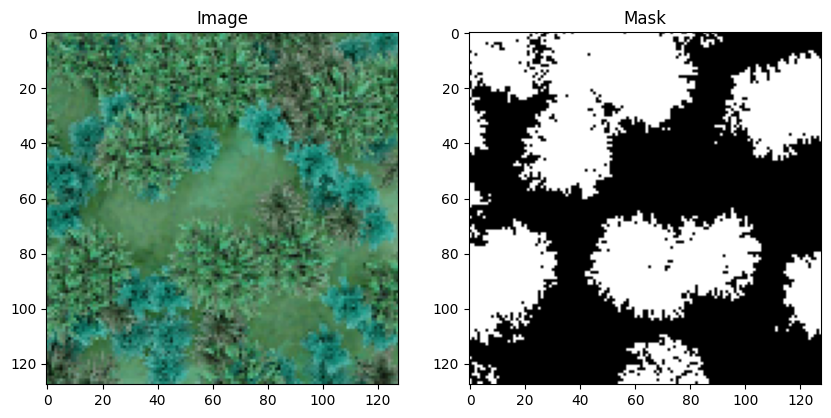

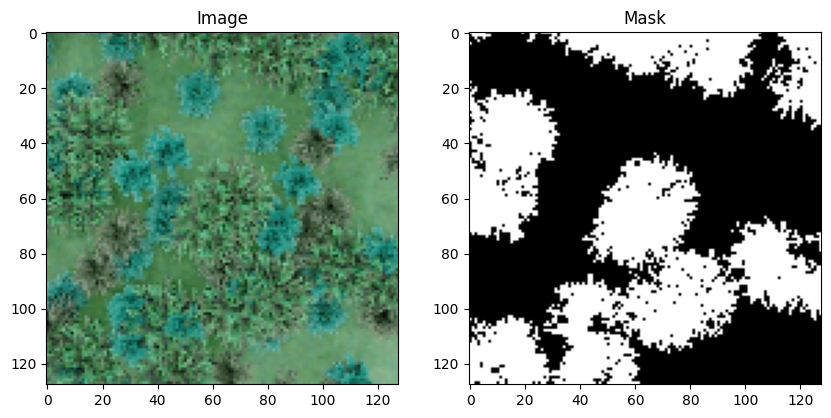

In [49]:
show_image_and_mask(0, X_train, y_train)
show_image_and_mask(100, X_train, y_train)

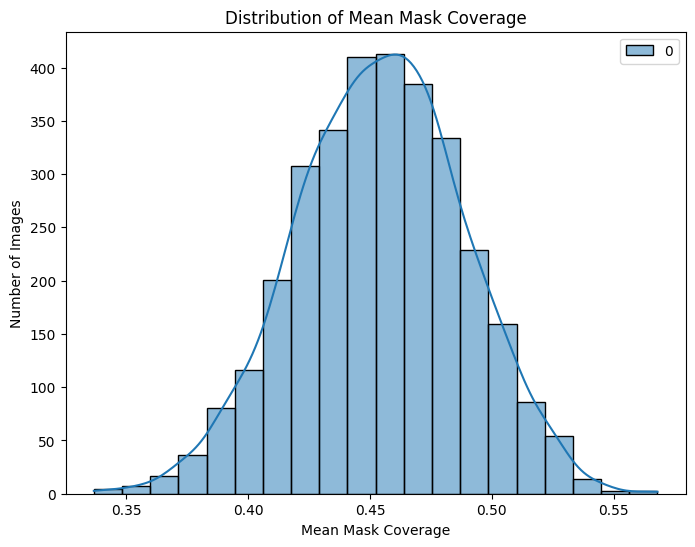

In [50]:
plot_mask_coverage_distribution(y_train)


In [51]:
X_train = rescale_images(X_train)
kaggle_data = rescale_images(Kaggle_data)

print(np.max(X_train))
print(np.max(kaggle_data))

1.0
1.0


In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

In [53]:
generator = create_train_generator(X_train, y_train, 32, SEED)

In [54]:
class UNetWithPretrainedEncoder:
    def __init__(self, input_shape=(128, 128, 3), dropout_rate=0.0, learning_rate=0.001, activation='relu'):
        self.input_shape = input_shape
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.activation = activation

    def build_model(self):
        # Load the pretrained VGG16 model as the encoder, with weights pre-trained on ImageNet.
        encoder = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        
        # Capture the encoder layers we’ll use as skip connections.
        inputs = encoder.input  # This becomes the input layer of our U-Net
        skip1 = encoder.get_layer("block1_conv2").output  # 64x64x64
        skip2 = encoder.get_layer("block2_conv2").output  # 32x32x128
        skip3 = encoder.get_layer("block3_conv3").output  # 16x16x256
        skip4 = encoder.get_layer("block4_conv3").output  # 8x8x512
        bottleneck = encoder.get_layer("block5_conv3").output  # 4x4x512

        # Decoder Block 1
        u4 = UpSampling2D((2, 2))(bottleneck)
        u4 = concatenate([u4, skip4])
        c4 = Conv2D(512, (3, 3), padding='same')(u4)
        c4 = self._apply_activation(c4)
        c4 = BatchNormalization()(c4)
        c4 = Conv2D(512, (3, 3), padding='same')(c4)
        c4 = self._apply_activation(c4)
        c4 = BatchNormalization()(c4)

        # Decoder Block 2
        u3 = UpSampling2D((2, 2))(c4)
        u3 = concatenate([u3, skip3])
        c3 = Conv2D(256, (3, 3), padding='same')(u3)
        c3 = self._apply_activation(c3)
        c3 = BatchNormalization()(c3)
        c3 = Conv2D(256, (3, 3), padding='same')(c3)
        c3 = self._apply_activation(c3)
        c3 = BatchNormalization()(c3)

        # Decoder Block 3
        u2 = UpSampling2D((2, 2))(c3)
        u2 = concatenate([u2, skip2])
        c2 = Conv2D(128, (3, 3), padding='same')(u2)
        c2 = self._apply_activation(c2)
        c2 = BatchNormalization()(c2)
        c2 = Conv2D(128, (3, 3), padding='same')(c2)
        c2 = self._apply_activation(c2)
        c2 = BatchNormalization()(c2)

        # Decoder Block 4
        u1 = UpSampling2D((2, 2))(c2)
        u1 = concatenate([u1, skip1])
        c1 = Conv2D(64, (3, 3), padding='same')(u1)
        c1 = self._apply_activation(c1)
        c1 = BatchNormalization()(c1)
        c1 = Conv2D(64, (3, 3), padding='same')(c1)
        c1 = self._apply_activation(c1)
        c1 = BatchNormalization()(c1)

        # Output Layer
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(c1)

        # Compile Model
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss="binary_crossentropy", metrics=[F1_score,'accuracy', TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])
        return model

    def _apply_activation(self, x):
        return Relu(x)
    
    def train_model(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=50):
        model = self.build_model()
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            batch_size=batch_size, epochs=epochs,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        return model, history

    def train_model_with_generator(self, train_generator, X_val, y_val, batch_size=32, epochs=50, steps_per_epoch=100):
        model = self.build_model()
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3)

        history = model.fit(train_generator,
                            validation_data=(X_val, y_val),
                            steps_per_epoch=steps_per_epoch,
                            batch_size=batch_size, epochs=epochs,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        return model, history


In [55]:
VGG16_unet = UNetWithPretrainedEncoder()

In [56]:
mode, history = VGG16_unet.train_model(X_train, y_train, X_val, y_val, batch_size=32, epochs=100)

2024-10-30 19:10:47.751163: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 503316480 exceeds 10% of free system memory.
2024-10-30 19:10:48.294337: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 503316480 exceeds 10% of free system memory.


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.8637 - f1_score: 0.8519 - false_negatives_2: 1121218.5000 - false_positives_2: 1252025.7500 - loss: 0.3085 - true_negatives_2: 10502146.0000 - true_positives_2: 8613945.0000 - val_accuracy: 0.9041 - val_f1_score: 0.9011 - val_false_negatives_2: 192121.0000 - val_false_positives_2: 813108.0000 - val_loss: 0.2556 - val_true_negatives_2: 4898732.0000 - val_true_positives_2: 4581799.0000 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9301 - f1_score: 0.9230 - false_negatives_2: 714045.1250 - false_positives_2: 776148.3125 - loss: 0.1697 - true_negatives_2: 10978024.0000 - true_positives_2: 9021118.0000 - val_accuracy: 0.9151 - val_f1_score: 0.9105 - val_false_negatives_2: 247506.0000 - val_false_positives_2: 642817.0000 - val_loss: 0.2164 - val_true_negatives_2: 5069023.0000 - val_true_positives_2: 4526414.0000 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 1

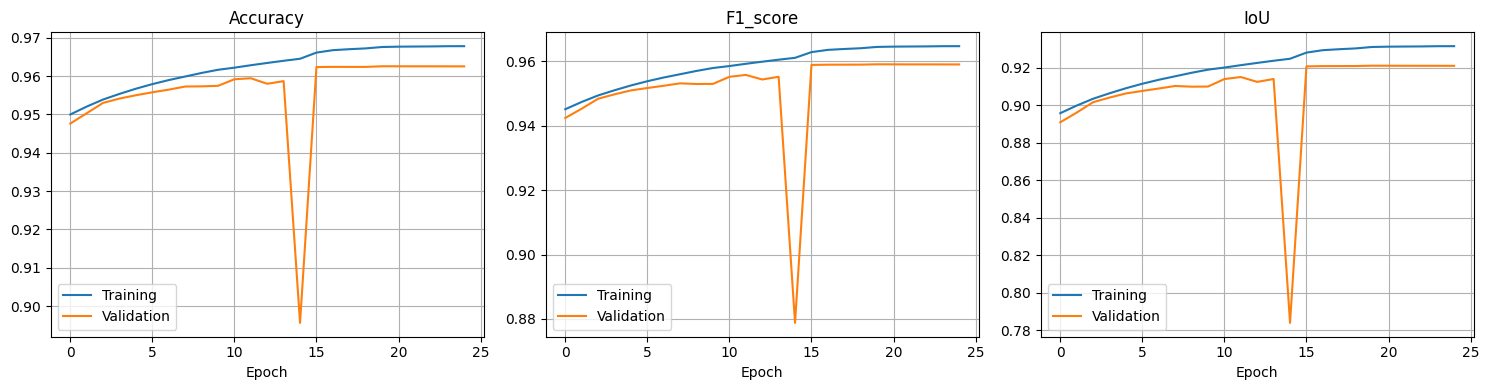

In [57]:
plot_training_history(history, list_of_metrics=['Accuracy', 'F1_score', 'IoU'], start_epoch=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


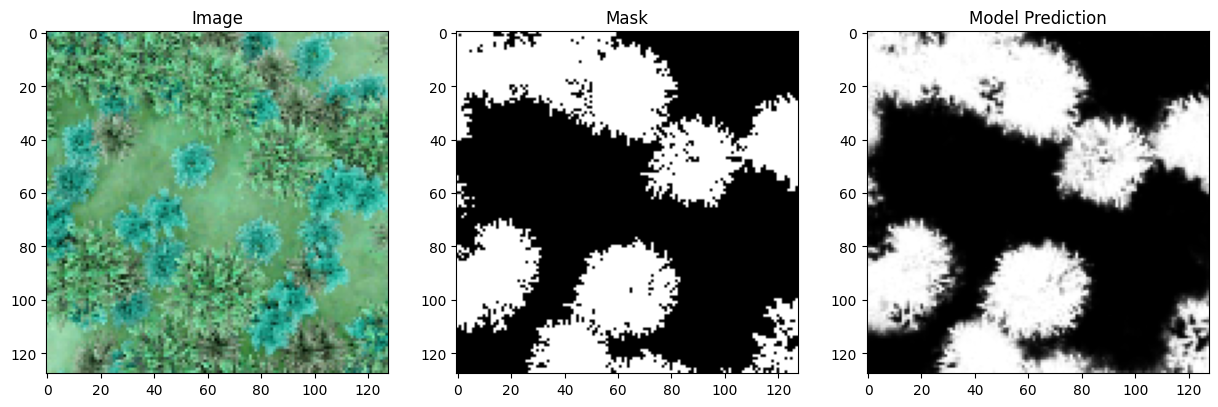

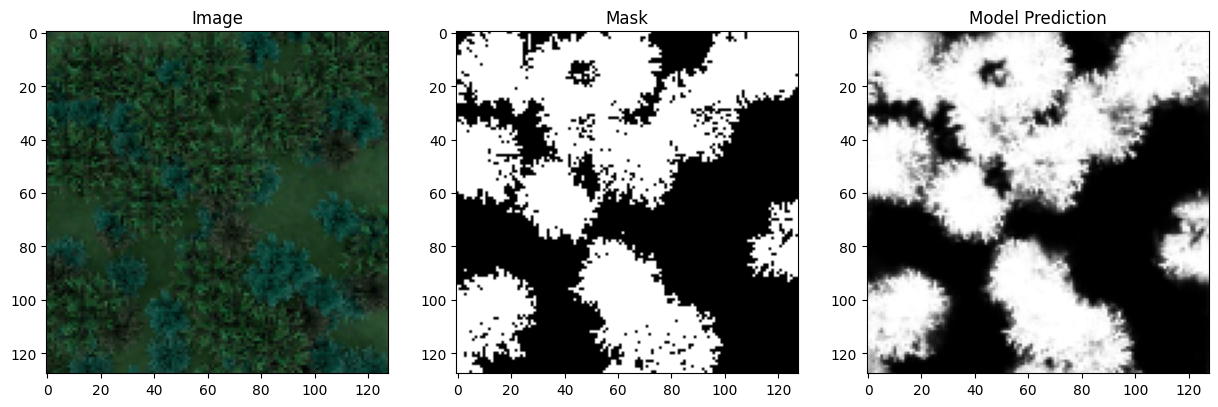

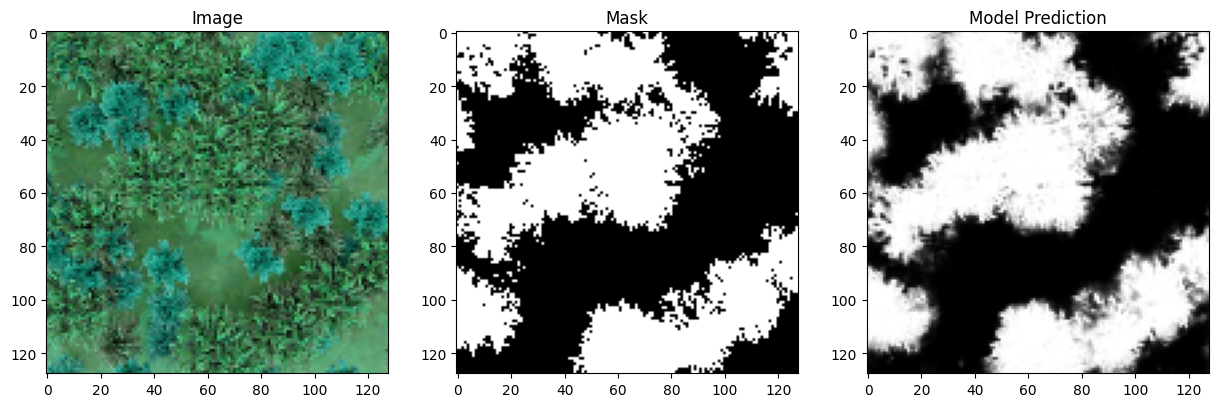

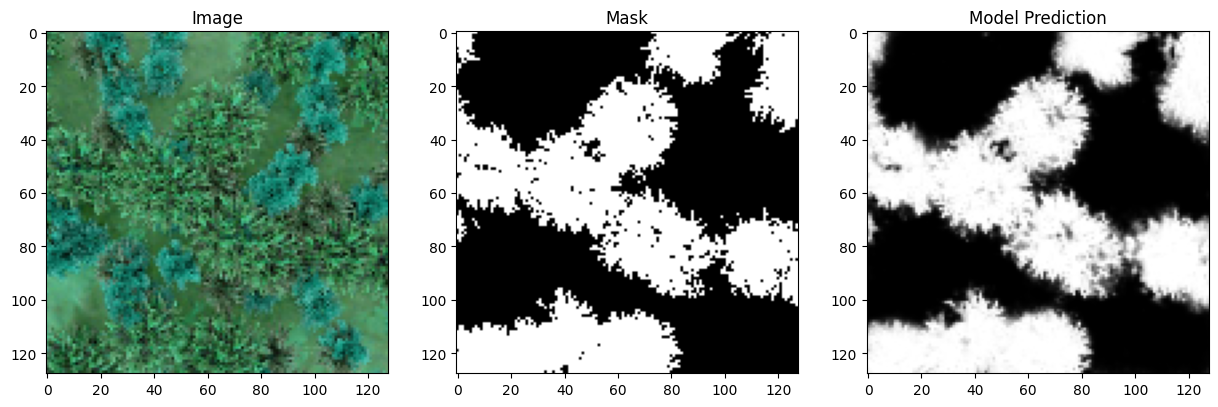

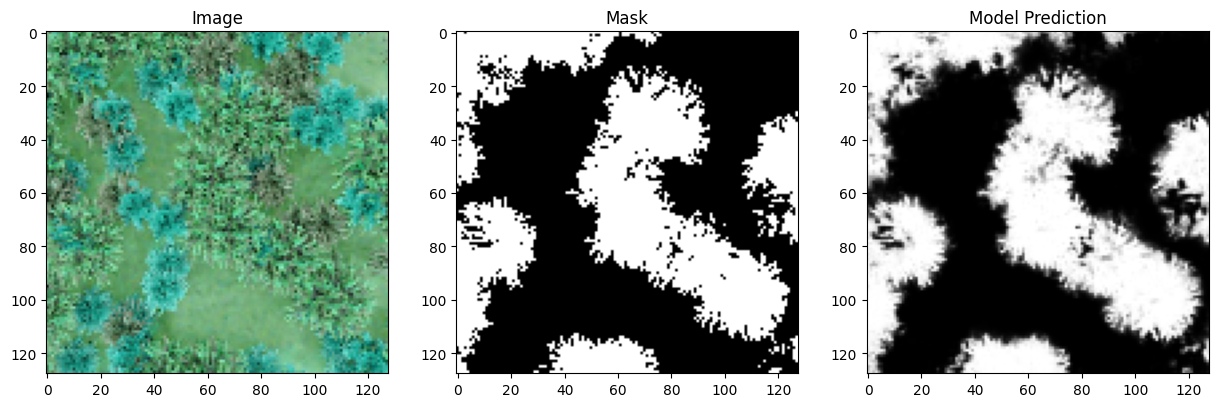

In [58]:
plot_predictions(model, X_val, y_val, num_images=5)

In [60]:
# Threshold for sigmoid
USER_DETERMINED_THRESHOLD = 0.5

y_pred      = model.predict(kaggle_data)  # Make prediction using the trained model
flat_y_pred = y_pred.flatten()                             # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1  # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                        # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))               # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
